# Author network
This notebook explores building a network with authors as nodes instead of papers, using both co-authorships and citations as edges/weights.

In [2]:
import networkx as nx
import jsonlines
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations, permutations

## Read & pre-process data

In [3]:
graph = nx.read_graphml('../data/citation_network/core_collection_destol_or_anhydro_FILTERED_classified_network_06Jan2023_MANUALLY_VERIFIED.graphml')

In [4]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_ALL_with_authors_18Jan2024_parallel.jsonl') as reader:
    papers = [obj for obj in reader]

In [5]:
# Index by paper
paper_authors = defaultdict(list)
for paper in papers:
    uid = paper['UID']
    for author in paper['authors']:
        try:
            paper_authors[uid].append(author['wos_standard'])
        except KeyError:
            continue

In [6]:
# Index by author
author_papers = defaultdict(list)
for paper in papers:
    uid = paper['UID']
    for author in paper['authors']:
        try:
            author_papers[author['wos_standard']].append(uid)
        except KeyError:
            continue

In [7]:
print(f'There are {len(author_papers)} unique author names in the dataset.')

There are 18036 unique author names in the dataset.


Text(0, 0.5, 'Frequency')

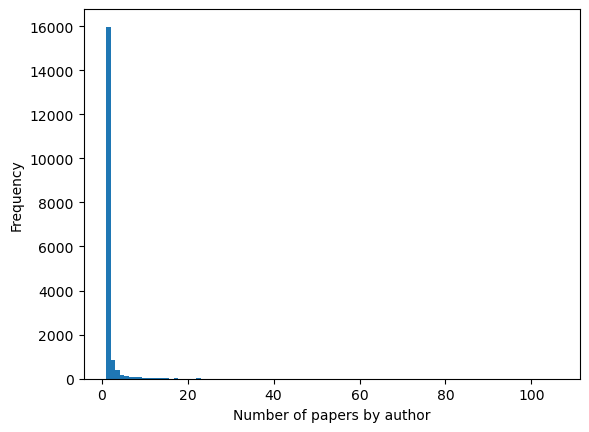

In [8]:
paper_nums = [len(v) for k,v in author_papers.items()]
_ = plt.hist(paper_nums, bins=100)
plt.xlabel('Number of papers by author')
plt.ylabel('Frequency')

In [9]:
cutoff = 3
print(f'{100*(len([i for i in paper_nums if i > cutoff])/len(paper_nums)):.2f} percent of authors have more than {cutoff} papers.')

6.75 percent of authors have more than 3 papers.


We'll remove authors with fewer than 3 papers from the dataset for the sake of building the people network, as it'll greatly simplify the resulting visuals and will make them more meaningful.

In [10]:
thresholded = {k:v for k,v in author_papers.items() if len(v) > cutoff}
print(f'There are {len(thresholded)} authors remaining in the dataset.')

There are 1218 authors remaining in the dataset.


## Building people network
There are two kinds of links we'll consider in our network building; co-authorships, and citations. .

### Co-author network

In [11]:
co_authorship_weights = defaultdict(int)
for paper in papers:
    authors = []
    for author in paper['authors']:
        try:
            if author['wos_standard'] in thresholded.keys():
                authors.append(author['wos_standard'])
        except KeyError:
            continue
    all_author_pairs = combinations(authors, 2)
    for author_pair in all_author_pairs:
        if author_pair[0] != author_pair[1]:
            co_authorship_weights[author_pair] += 1
# Combine reverse-ordered pair counts for edges
co_author_joined_weights = defaultdict(int)
for pair, val in co_authorship_weights.items():
    co_author_joined_weights[tuple(set(pair))] += val
edges = [(c[0], c[1], {'weight': w}) for c, w in co_author_joined_weights.items()]

In [12]:
co_author_graph = nx.Graph()
_ = co_author_graph.add_edges_from(edges)

In [13]:
nx.write_graphml(co_author_graph, '../data/citation_network/co_author_graph_thresh_3_26Jan2023.graphml')

### Citation network

In [21]:
co_citation_weights = defaultdict(int)
for edge in graph.edges:
    for author1 in paper_authors[edge[0]]:
        for author2 in paper_authors[edge[1]]:
            if author1 != author2:
                if (author1 in thresholded.keys()) and (author2 in thresholded.keys()):
                    author_pair = tuple(set([author1, author2]))
                    co_citation_weights[author_pair] += 1
edges = [(e[0], e[1], {'weight': w}) for e, w in co_citation_weights.items()]

In [22]:
co_citation_graph = nx.Graph()
_ = co_citation_graph.add_edges_from(edges)

In [23]:
nx.write_graphml(co_citation_graph, '../data/citation_network/co_citation_graph_thresh_3_26Jan2023.graphml')